### 개선방향
- `04_03_FE_means.ipynb`에서 전처리를 완료한 데이터를 사용하여 LightGBM을 학습
- 

# Module

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm.callback import log_evaluation#, early_stopping
# import optuna
# from optuna.integration import LightGBMPruningCallback
# from optuna.samplers import TPESampler
# from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

# Data

In [2]:
data_path = "./data/"

all_data = joblib.load(data_path + 'all_data2.joblib')
sub = pd.read_csv(data_path + 'sample_submission.csv')

In [3]:
all_data = all_data.drop(columns='item_id')
all_data.shape

(8812244, 56)

# Model

## prepare

In [4]:
x_train = all_data[all_data['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_month'], axis=1)

x_val = all_data[all_data['date_block_num'] == 33]
x_val = x_val.drop(['item_cnt_month'], axis=1)

x_test = all_data[all_data['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis=1)

y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
y_val = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

x_all = pd.concat([x_train, x_val])
y_all = pd.concat([y_train, y_val])

del all_data

In [6]:
cat_features = ['shop_id', 'type', 'subtype', 'shop_type', 'shop_category', 'item_category_id', 'city', 'month']
dtrain_all = lgb.Dataset(x_all, y_all, categorical_feature=cat_features)

## train

- `05_02_lgbm_shopcats.ipynb`와 하이퍼 파라미터 동일하게 설정

In [7]:
best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'force_col_wise': True,
    'random_state': 2025,
    'verbosity': -1,
    'num_leaves' : 230,
    'learning_rate' : 0.04794760090885384,
    'feature_fraction' : 0.7565706439029963,
    'bagging_fraction' : 0.9382478206260831,
    'bagging_freq' : 1,
}

best_iter = 300
final_iter = int(best_iter * 1.3)

In [8]:
%%time

final_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain_all,
    num_boost_round=final_iter,
    valid_sets=[dtrain_all],
    callbacks=[
        log_evaluation(period=100)
    ]
)

[100]	training's rmse: 0.829527
[200]	training's rmse: 0.804299
[300]	training's rmse: 0.789729
CPU times: user 14min 32s, sys: 7.03 s, total: 14min 39s
Wall time: 4min 2s


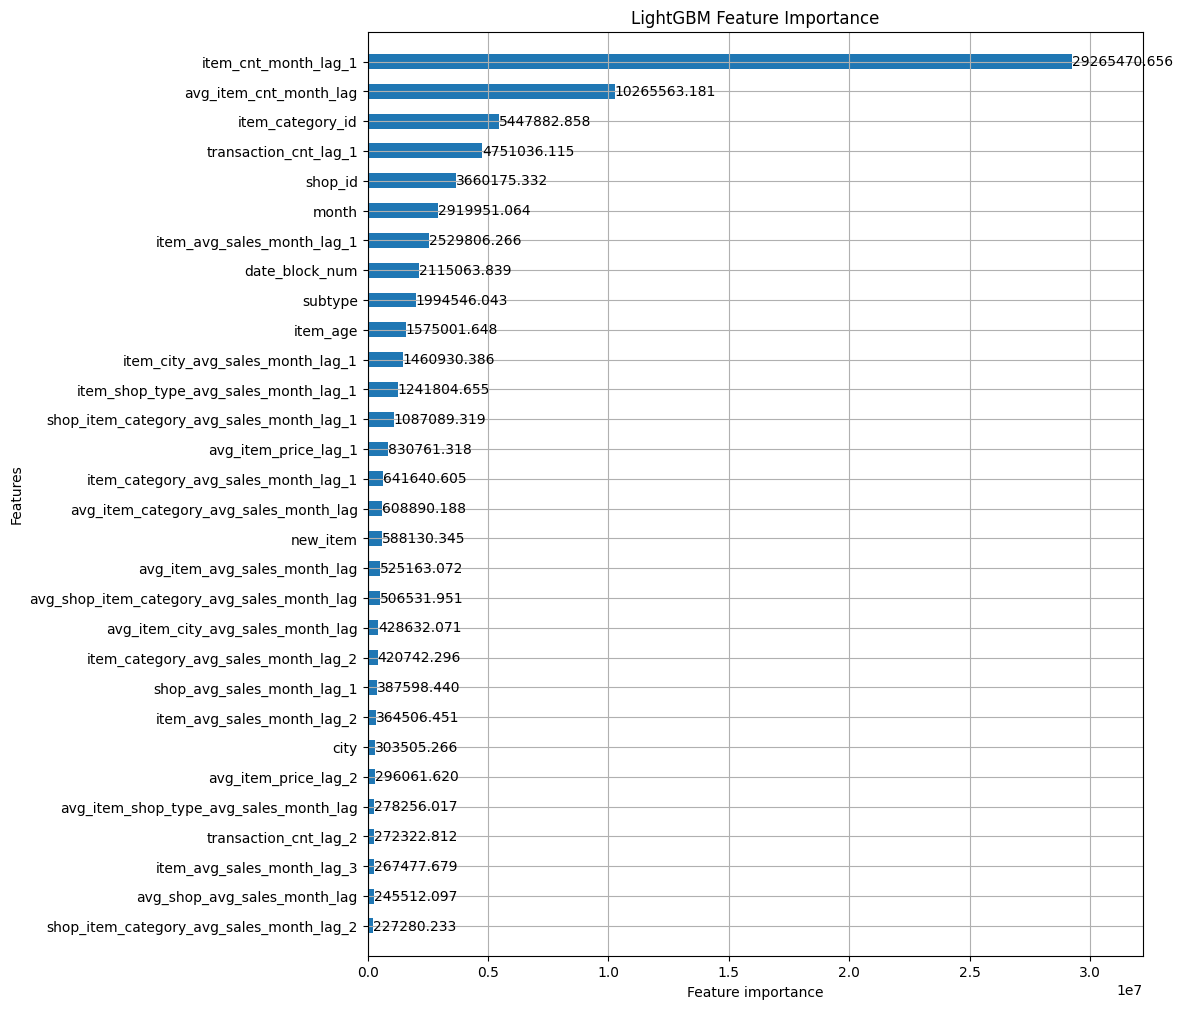

In [9]:
plt.figure(figsize=(10, 12)) 
lgb.plot_importance(final_lgbm_model, max_num_features=30, height=0.5, ax=plt.gca(), importance_type='gain')
plt.title('LightGBM Feature Importance')
plt.show()

In [10]:
final_lgbm_model.save_model(data_path + '05_04_lgbm_model.txt')

## prediction

In [11]:
final_lgbm_model = lgb.Booster(model_file='./data/05_04_lgbm_model.txt')

In [12]:
predictions = final_lgbm_model.predict(x_test).clip(0, 20)
sub['item_cnt_month'] = predictions
sub.head()

,ID,item_cnt_month
0,0,0.792627
1,1,0.288316
2,2,0.847785
3,3,0.733027
4,4,3.524573


In [13]:
print(pd.Series(predictions).describe())

count    214200.000000
mean          0.296623
std           0.867042
min           0.000000
25%           0.018792
50%           0.075919
75%           0.249434
max          20.000000
dtype: float64


In [14]:
sub.to_csv(data_path + '05_04_submssion_lgbm_model.csv', index=False)

In [15]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/05_04_submssion_lgbm_model.csv" -m "05_04_submssion_lgbm_model"

100%|██████████████████████████████████████| 5.18M/5.18M [00:00<00:00, 12.0MB/s]
Successfully submitted to Predict Future Sales

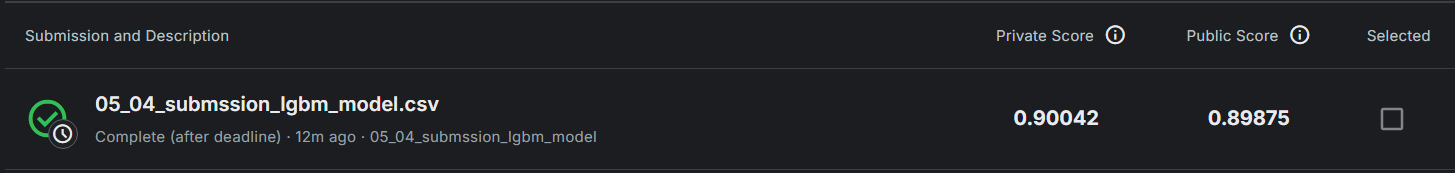
- 다수의 lag 변수를 추가하였으나 성능 하락